<a href="https://colab.research.google.com/github/njocimar28/Perfil-Investidor/blob/main/Perfil_de_investimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perfil de investimento

### Tratamento de dados

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import joblib

In [124]:
dados_clientes = pd.read_csv("/content/dados_clientes_financeira.csv", encoding='ISO-8859-15', sep=';')

dados_clientes.head(2)

,ID_cliente,genero,escolaridade,idade,estado_civil,id_estado
0,1,Masculino,Graduação,65.0,Viúvo,10
1,2,Masculino,Pós-graduação,39.0,Casado,5


In [125]:
dados_estado = pd.read_csv("/content/estado_regiao.csv", encoding='ISO-8859-15', sep=';')

dados_estado.head(2)

,id_estado,sigla,estado,regiao,pais
0,1,AC,Acre,Norte,Brasil
1,2,AL,Alagoas,Nordeste,Brasil


In [126]:
dados_invest = pd.read_csv("/content/investimentos_clientes.csv", encoding='ISO-8859-15', sep='|')

dados_invest.head(2)

,ID_cliente,tipo_transacao_mais_frequente,tolerancia_risco,valor_investido,valor_investido_acoes,valor_investido_fii,valor_investido_dolar,valor_investido_renda_fixa,perfil
0,1,Investimentos,Baixa,971843,47473,581110,196765,146495,Conservador
1,2,Transferências,Moderado,20594,5369,4009,6662,4554,Moderado


In [127]:
dados_completos_inter = pd.merge(dados_clientes, dados_estado, on='id_estado', how='left')

dados_completos_inter.head(2)

,ID_cliente,genero,escolaridade,idade,estado_civil,id_estado,sigla,estado,regiao,pais
0,1,Masculino,Graduação,65.0,Viúvo,10,MA,Maranhão,Nordeste,Brasil
1,2,Masculino,Pós-graduação,39.0,Casado,5,BA,Bahia,Nordeste,Brasil


In [128]:
dados_completos = pd.merge(dados_completos_inter, dados_invest, on='ID_cliente', how='left')

dados_completos.head(2)

,ID_cliente,genero,escolaridade,idade,estado_civil,id_estado,sigla,estado,regiao,pais,tipo_transacao_mais_frequente,tolerancia_risco,valor_investido,valor_investido_acoes,valor_investido_fii,valor_investido_dolar,valor_investido_renda_fixa,perfil
0,1,Masculino,Graduação,65.0,Viúvo,10,MA,Maranhão,Nordeste,Brasil,Investimentos,Baixa,971843,47473,581110,196765,146495,Conservador
1,2,Masculino,Pós-graduação,39.0,Casado,5,BA,Bahia,Nordeste,Brasil,Transferências,Moderado,20594,5369,4009,6662,4554,Moderado


In [129]:
dados_completos.shape[0]

1027

In [130]:
dados_completos_limpo = dados_completos.drop_duplicates()

In [131]:
dados_completos_limpo.shape[0]

1000

In [132]:
# Verificando valores nulos em cada coluna e contando
valores_nulos_por_coluna = dados_completos_limpo.isnull().sum()

print(valores_nulos_por_coluna)

ID_cliente                        0
genero                            0
escolaridade                      5
idade                            14
estado_civil                      0
id_estado                         0
sigla                             0
estado                            0
regiao                            0
pais                              0
tipo_transacao_mais_frequente     0
tolerancia_risco                  0
valor_investido                   0
valor_investido_acoes             0
valor_investido_fii               0
valor_investido_dolar             0
valor_investido_renda_fixa        0
perfil                            0
dtype: int64


In [133]:
# Calcula a moda da coluna 'escolaridade'
moda_escolaridade = dados_completos_limpo['escolaridade'].mode()[0]

# Cria uma cópia do DataFrame antes de preencher os valores nulos
dados_completos_limpo = dados_completos_limpo.copy()

# Preenche os valores nulos na coluna 'escolaridade' com a moda
dados_completos_limpo['escolaridade'].fillna(moda_escolaridade, inplace=True)

In [134]:
media_idade_por_genero = dados_completos_limpo.groupby('genero')['idade'].mean()

# Preenche os valores nulos na coluna 'Idade' com a média correspondente ao gênero
for genero, media_idade in media_idade_por_genero.items():
    dados_completos_limpo.loc[(dados_completos_limpo['genero'] == genero) & (dados_completos_limpo['idade'].isnull()), 'idade'] = media_idade

In [135]:
# Verificando valores nulos em cada coluna e contando
valores_nulos_por_coluna = dados_completos_limpo.isnull().sum()

print(valores_nulos_por_coluna)

ID_cliente                       0
genero                           0
escolaridade                     0
idade                            0
estado_civil                     0
id_estado                        0
sigla                            0
estado                           0
regiao                           0
pais                             0
tipo_transacao_mais_frequente    0
tolerancia_risco                 0
valor_investido                  0
valor_investido_acoes            0
valor_investido_fii              0
valor_investido_dolar            0
valor_investido_renda_fixa       0
perfil                           0
dtype: int64


In [136]:
dados_completos_limpo.to_csv("dados_completos_limpo.csv", sep=';', index=False, encoding='utf-8')

### Criando um modelo para identificar o perfil de investimento

In [137]:
lista_features = [
    'genero',
    'escolaridade',
    'idade',
    'estado_civil',
    'regiao',
    'valor_investido',
    'valor_investido_acoes',
    'valor_investido_fii',
    'valor_investido_dolar',
    'valor_investido_renda_fixa'
]

In [138]:
dados_completos_transformados = dados_completos_limpo.copy()

# Mapeando as colunas conforme as transformações necessárias
genero_mapping = {'Masculino': 0, 'Feminino': 1}
estado_civil_mapping = {'Casado': 0, 'Divorciado': 1, 'Solteiro': 2, 'Viúvo': 3}
escolaridade_mapping = {'Ensino Médio': 0, 'Graduação': 1, 'Pós-graduação': 2}
regiao_mapping = {'Centro-Oeste': 0, 'Nordeste': 1, 'Norte': 2, 'Sudeste': 3, 'Sul': 4}

# Aplicando os mapeamentos ao DataFrame copiado
dados_completos_transformados['genero'] = dados_completos_transformados['genero'].map(genero_mapping)
dados_completos_transformados['estado_civil'] = dados_completos_transformados['estado_civil'].map(estado_civil_mapping)
dados_completos_transformados['escolaridade'] = dados_completos_transformados['escolaridade'].map(escolaridade_mapping)
dados_completos_transformados['regiao'] = dados_completos_transformados['regiao'].map(regiao_mapping)

In [139]:
features = dados_completos_transformados[lista_features]  # Substitua pelas suas colunas de recursos
target = dados_completos_transformados['perfil']  # Substitua pelo nome da sua variável alvo

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(features, target)

# Redução de exemplos com TomekLinks
tl = TomekLinks(sampling_strategy='all')
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled)

# Divisão dos dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Criando o modelo RandomForestClassifier com os parâmetros especificados
clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=100)

# Treinando o modelo com os dados de treino
clf.fit(X_train, y_train)

# Fazendo previsões com os dados de teste
y_pred = clf.predict(X_test)

In [140]:
# Avaliando a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do RandomForestClassifier: {accuracy:.2f}")

Acurácia do RandomForestClassifier: 0.87


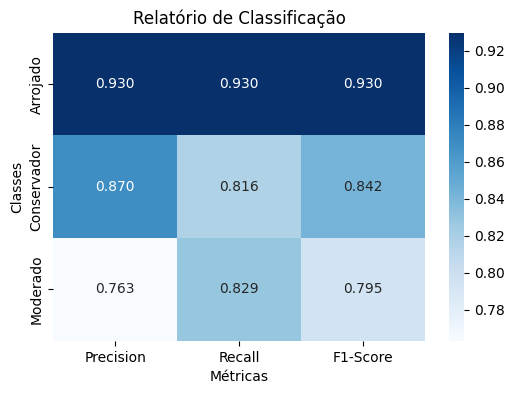

In [141]:
# Gerando o relatório de classificação
report = classification_report(y_test, y_pred, target_names=[str(i) for i in clf.classes_])

# Convertendo o relatório para um dicionário para facilitar a visualização
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Plotando as métricas de precisão, recall e f1-score
plt.figure(figsize=(6, 4))
sns.heatmap([[report_dict[str(clf.classes_[i])][metric] for metric in ['precision', 'recall', 'f1-score']] for i in range(len(clf.classes_))],
            annot=True, fmt=".3f", cmap="Blues", xticklabels=['Precision', 'Recall', 'F1-Score'],
            yticklabels=[str(i) for i in clf.classes_])
plt.xlabel('Métricas')
plt.ylabel('Classes')
plt.title('Relatório de Classificação')
plt.show()

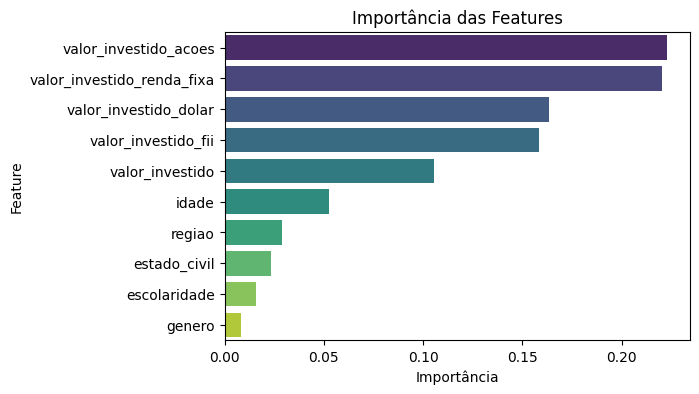

In [142]:
## Acessando a importância das features
importancias_features = clf.feature_importances_

# Criando um DataFrame para melhor visualização das importâncias
importancias_df = pd.DataFrame({'Feature': features.columns, 'Importância': importancias_features})
importancias_df = importancias_df.sort_values(by='Importância', ascending=False)

# Plotando as importâncias das features
plt.figure(figsize=(6, 4))
sns.barplot(x='Importância', y='Feature', data=importancias_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Importância das Features')
plt.show()

In [143]:
# Caminho para salvar o modelo
caminho_modelo = 'modelo_random_forest_ivestimento.pkl'

# Salvar o modelo
joblib.dump(clf, caminho_modelo)
print(f'Modelo salvo em {caminho_modelo}')

Modelo salvo em modelo_random_forest_ivestimento.pkl
